# A Comparison of America’s Large Cities In Terms of Access to Ethnic Foods

### Applied Data Science Capstone by IBM/Coursera - The Battle of Neighborhoods

### Author: Fereshteh Bashiri

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

Over the past two hundred years, many immigrants have opted for large cities in the US, such as Chicago, NYC, Los Angeles, etc., resulting in abundant **ethnic restaurants** in major cities. In this project, we are going to explore some **major US cities** in terms of diversity and access to local cuisines. While such an exploration provides useful insights into the culture and common traditions in these areas, inherited from the first generations of immigrants, we will particularly look for tentative business opportunities. Ultimately we want to find out:
* Whether one can trace the history of immigration to these cities?
* What type of cuisine is not well-represented, which may have the potential to invest?

## Data  <a name="data"></a>

To explore and compare cities in terms of ethnic foods, we will need the kind and frequency of available ethnic foods around downtown. Such information will be obtained using **Foursquare API**, providing latitude and longitude of each city. The geographical coordinates of cities can be obtained usig **Nominatim Geocoder**.

Let's first import some useful packages.

In [1]:
import pandas as pd
import numpy as np
import requests
from geopy.geocoders import Nominatim  # geospatial coordinates

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import folium

Then, we create a list of cities of interest and their corresponding states. Next, we use Nominatim geolocator to obtain their geographical coordinates. The information will be stored in a Dataframe.

In [2]:
# create a Dataframe of cities and their corresponding states
cities_list = [['New York','NY'], ['Boston','MA'], ['Philadelphia','PA'], ['Chicago','IL'], ['Houston','TX'],
               ['Denver','CO'], ['San Francisco','CA'], ['Seattle','WA'], ['Indianapolis','IN'], ['Madison','WI'], 
               ['Albuquerque','NM'], ['Atlanta','GA'], ['Columbus','OH'], ['Phoenix', 'AZ'], ['Dallas','TX']]
df_cities = pd.DataFrame(cities_list, 
                         columns=['City','State'])

# download geospatial coordinates
latlng_list = []
print('Downloading geographical coordinates of:')
for i in range(df_cities.shape[0]):
    print('{}, {} ... '.format(df_cities.loc[i,'City'], df_cities.loc[i,'State']), end='')
    address = '{}, {}, USA'.format(df_cities.loc[i,'City'], df_cities.loc[i,'State'])
    geolocator = Nominatim(user_agent='my_explorer')
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    latlng_list.append([latitude, longitude])
print('Done!')

# concatenate latlng_list to the Dataframe
df_cities = df_cities.join(pd.DataFrame(latlng_list, index=df_cities.index, columns=['Latitude','Longitude']))



New York, NY ... Boston, MA ... Philadelphia, PA ... Chicago, IL ... Houston, TX ... Denver, CO ... San Francisco, CA ... Seattle, WA ... Indianapolis, IN ... Madison, WI ... Albuquerque, NM ... Atlanta, GA ... Columbus, OH ... Phoenix, AZ ... Dallas, TX ... Done!


Let's take a look at the Dataframe:

In [3]:
# print Dataframe of cities 
df_cities


,City,State,Latitude,Longitude
0,New York,NY,40.712728,-74.006015
1,Boston,MA,42.360253,-71.058291
2,Philadelphia,PA,39.952724,-75.163526
3,Chicago,IL,41.875562,-87.624421
4,Houston,TX,29.758938,-95.367697
5,Denver,CO,39.739236,-104.984862
6,San Francisco,CA,37.779281,-122.419236
7,Seattle,WA,47.603832,-122.330062
8,Indianapolis,IN,39.768333,-86.158350
9,Madison,WI,43.074761,-89.383761


####  Foursquare API

Now that we have collected geospatial coordinates of cities, we can feed them into Foursquare API and search for nearby restaurants. For that purpose, we need to define our foursquare credentials: 

In [4]:
CLIENT_ID = 'YYVEI3BSFIIROPFBI3MKO2D1TPYZYZWFADBW3XPZFKZJW1SF' # 'your-client-ID' # your Foursquare ID
CLIENT_SECRET = 'MZ2UYCNQQUB2IXRY143BXFLRKBL21YVAXOWEBH5RRV1KQB1L' #'your-client-secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200
RADIUS = 15000  # in meters

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: YYVEI3BSFIIROPFBI3MKO2D1TPYZYZWFADBW3XPZFKZJW1SF
CLIENT_SECRET:MZ2UYCNQQUB2IXRY143BXFLRKBL21YVAXOWEBH5RRV1KQB1L


As we need to send API request for each city separately, let's define a function that will go over a list of cities and send an API request per each item in the list. After collecting data for each item of the list, the function will extract useful information from the response and append it to the data collected for previous items. Finally, the function returns a DataFrame that contains four columns (city name, venue name, venue category, venue shortname) from all nearby restaurants. 


In [5]:
# A function that will create a list of veunues and their information within each item of the list (city)
def getNearbyVenues (names, latitudes, longitudes):
    
    venues_list = []
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore'
        params = dict(
            client_id=CLIENT_ID,
            client_secret=CLIENT_SECRET,
            v=VERSION, #'20180323',
            ll='{},{}'.format(lat, lng), #df_cities.loc[0,'Latitude'],df_cities.loc[0,'Longitude']),
            query='restaurant',
            #     section='food',
            intent='browse',
            limit=LIMIT,
            radius=RADIUS
        )

        # send get request
        data = requests.get(url=url, params=params).json()
        results = data['response']['groups'][0]['items']
        # results = data['response']['venues']  # for search, instead of explore
        # results   # for debugging purposes

        for v in results:
            venues_list.append([
                name,
                v['venue']['name'],
                v['venue']['categories'][0]['name'],
                v['venue']['categories'][0]['shortName']])
            

    nearby_venues = pd.DataFrame(venues_list, columns=['City',
                                                       'Venue Name',
                                                       'Venue Category',
                                                       'Venue ShortName'])
    
    # for debugging purposes
    # len(nearby_venues['Venue Category'].unique())
    # nearby_venues
    
    return(nearby_venues)

Now, let's run the above function on each city. 

In [6]:
# get restaurants within each city
df_venues = getNearbyVenues(names=df_cities['City'], 
                                 latitudes=df_cities['Latitude'], 
                                 longitudes=df_cities['Longitude'])

df_venues

,City,Venue Name,Venue Category,Venue ShortName
0,New York,Pisillo Italian Panini,Sandwich Place,Sandwiches
1,New York,Joe’s Pizza,Pizza Place,Pizza
2,New York,Takahachi Bakery,Bakery,Bakery
3,New York,Crown Shy,Restaurant,Restaurant
4,New York,Manhatta,New American Restaurant,New American
...,...,...,...,...
1495,Dallas,Lucia,Italian Restaurant,Italian
1496,Dallas,pōk,Sushi Restaurant,Sushi
1497,Dallas,Hook Line & Sinker,Seafood Restaurant,Seafood
1498,Dallas,Eddie V's Prime Seafood,Seafood Restaurant,Seafood


To remove irrelavent venues (like coffee shops, bakeries, etc), we will only keep rows that their "Venue Category" contains the term "Restaurant".

In [7]:
# keep rows that their "Venue Category" contains "Restaurant"
df_restaurant = df_venues[df_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
df_restaurant.head(10)

,City,Venue Name,Venue Category,Venue ShortName
0,New York,Crown Shy,Restaurant,Restaurant
1,New York,Manhatta,New American Restaurant,New American
2,New York,sweetgreen,Restaurant,Restaurant
3,New York,Le Coucou,French Restaurant,French
4,New York,Locanda Verde,Italian Restaurant,Italian
5,New York,Kiki's,Greek Restaurant,Greek
6,New York,Despaña,Spanish Restaurant,Spanish
7,New York,CAVA,Mediterranean Restaurant,Mediterranean
8,New York,Rubirosa Ristorante,Italian Restaurant,Italian
9,New York,sweetgreen,Restaurant,Restaurant


Let's print a summary of the collected data using the .shape method.

In [8]:
# print some information about the Dataframe
print('A summary of the collected information is as follows:')
print('\t Total number of citis: {}'.format(df_cities.shape[0]))
print('\t Total number of venues: {}'.format(df_venues.shape[0]))
print('\t The Number of unique venues (before filtering): {}'.format(len(df_venues['Venue ShortName'].unique())))
print('\t The number of unique venues (after filtering): {}.'.format(len(df_restaurant['Venue ShortName'].unique())))
print('\t The number of rows of the filtered datafram is: {}.'.format(df_restaurant.shape[0]))

A summary of the collected information is as follows:
	 Total number of citis: 15
	 Total number of venues: 1500
	 The Number of unique venues (before filtering): 93
	 The number of unique venues (after filtering): 61.
	 The number of rows of the filtered datafram is: 851.


## Analysis  <a name="analysis"></a>

In previous section, we collected a list of ethnnic restaurants within each city. 

In this section, we convert the df_restaurant DataFrame into a DataFrame in which columns are dummy variables representing all possible venue categories. Then we calculate the frequency (mean) of each venue category that has appeared in each city. 

In [9]:
# one hot encoding
venue_onehot = pd.get_dummies(df_restaurant[['Venue ShortName']], prefix="", prefix_sep="")

# add postal code to the table
venue_onehot.insert(0, 'City', df_restaurant['City'])
# venue_onehot.head()

# group by neighborhood and take the mean of the freq of occurence in each category
venue_onehot_freq = venue_onehot.groupby(by='City').mean()
venue_onehot_freq

,African,American,Arepas,Asian,Australian,Bavarian,Belgian,Brazilian,Burmese,Cajun / Creole,...,Southern / Soul,Spanish,Sushi,Szechuan,Tapas,Tex-Mex,Thai,Udon,Vegetarian / Vegan,Vietnamese
City,,,,,,,,,,,,,,,,,,,,,
Albuquerque,0.000000,0.113208,0.000000,0.037736,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,...,0.000000,0.018868,0.000000,0.000000,0.000000,0.000000,0.037736,0.000000,0.018868,0.056604
Atlanta,0.016393,0.147541,0.016393,0.016393,0.000000,0.000000,0.000000,0.000000,0.000000,0.016393,...,0.147541,0.016393,0.016393,0.000000,0.016393,0.000000,0.032787,0.000000,0.049180,0.032787
Boston,0.000000,0.084746,0.000000,0.033898,0.016949,0.000000,0.016949,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.033898,0.000000,0.016949,0.000000,0.000000,0.000000,0.033898,0.000000
Chicago,0.000000,0.102941,0.014706,0.014706,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.014706,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014706
Columbus,0.000000,0.291667,0.000000,0.000000,0.000000,0.020833,0.000000,0.000000,0.000000,0.041667,...,0.000000,0.000000,0.020833,0.000000,0.020833,0.000000,0.000000,0.000000,0.000000,0.000000
Dallas,0.000000,0.122807,0.000000,0.017544,0.000000,0.000000,0.000000,0.017544,0.000000,0.000000,...,0.052632,0.000000,0.035088,0.000000,0.017544,0.017544,0.052632,0.000000,0.035088,0.000000
Denver,0.000000,0.218182,0.000000,0.018182,0.000000,0.000000,0.000000,0.000000,0.000000,0.018182,...,0.018182,0.000000,0.054545,0.000000,0.018182,0.018182,0.018182,0.000000,0.036364,0.000000
Houston,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038462,...,0.019231,0.019231,0.038462,0.019231,0.000000,0.000000,0.019231,0.000000,0.000000,0.096154
Indianapolis,0.000000,0.148148,0.000000,0.018519,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,...,0.055556,0.018519,0.037037,0.000000,0.000000,0.000000,0.018519,0.000000,0.018519,0.000000


The output is a DataFrame with 15 rows (the total number of cities) and 61 columns (the number of unique types of restaurants after filtering out).

Our first step in analyzing the data is to visualize it. We have collected the appearance rate of 61 different ethnic restaurants in downtown area of 15 US cities. In other words, the data represents 61 features from 15 samples. It is not feasible to visualize a 61-dimensional data. Therefore, we are going to project the data on a 2D plane using a dimensionality reduction technique called Principal Component Analysis (PCA). 

PCA projects the data into _m_ orthogonal directions in which the data has maximum variations. The projected data is called **scores** and vectors along which the data is projected are called **loadings**. We are going to plot principal component scores and the first 10 loading vectors with the largest magnitude in a single **biplot** figure.



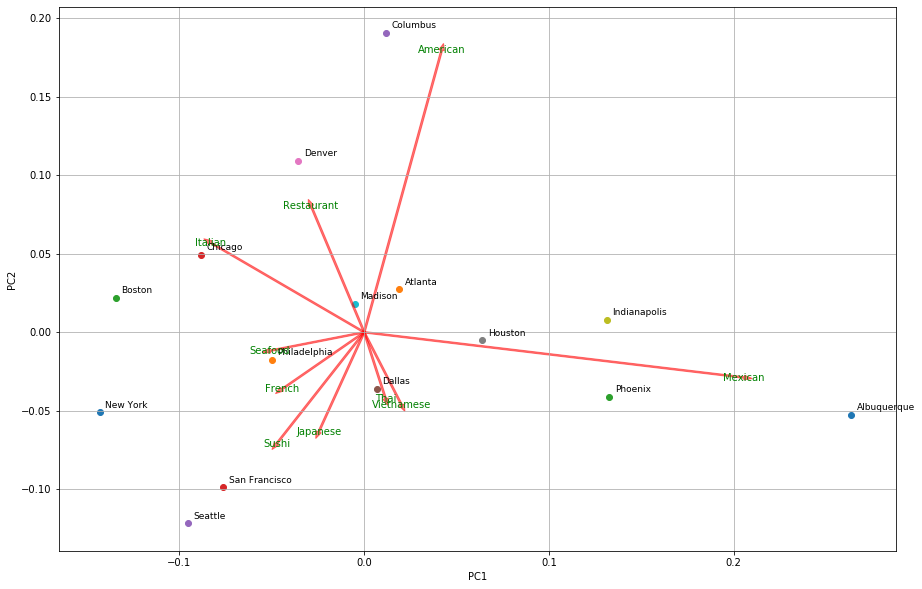

In [10]:
# instantiate a PCA object and transform data
pca = PCA(n_components=2, random_state=1)
x_reduced = pca.fit_transform(venue_onehot_freq)
x_reduced = pd.DataFrame(x_reduced, columns=['c1','c2']).set_index(venue_onehot_freq.index.values)
# x_reduced

# create a plot
offset = 0.003
fig, ax = plt.subplots(figsize=(15, 10))
# scatter plot and annotate
for x, y, city in zip(x_reduced['c1'], x_reduced['c2'], x_reduced.index.values):
    ax.scatter(x, y)
    plt.text(x+offset, y+offset, city, fontsize=9)

# compute 10 loadings with largest magnitude
coeff = np.transpose(pca.components_[0:2, :])
ind = np.linalg.norm(coeff, axis=1).argsort()[-10:][::-1] 
for i in ind:
    plt.arrow(0, 0, coeff[i,0]*0.25, coeff[i,1]*0.25, color = 'r',alpha = 0.5)
    plt.text(coeff[i,0]*0.25, coeff[i,1]*0.25, venue_onehot_freq.columns[i], color = 'g', ha = 'center', va = 'center')
    
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()
plt.show()

# pca.components_



We will discuss the above figure in details in the [Results and Discussion](#results) section. Just as a brief observation, it is interesting how cities with a great number of Mexican residents are separated from other cities by spreading along Mexican loading vector, and San Francisco is in the direction of Sushi loading vector.


To obtain a better understanding of the above plot, let's look at the distribution of different cuisines at each city separately. In other words, we are interested in finding out what are the most common types of restaurant in each city. For that purpose, we are going to find top 5 most frequent cuisines and the average number of their appearance. 

In [11]:
num_top_venues = 5

for city in venue_onehot_freq.index.values:
    print("---- "+city+" ----")
    col_indx = np.flip(np.argsort(venue_onehot_freq.loc[city].to_numpy())[-num_top_venues:])
    sorted_data = pd.DataFrame({'venue':venue_onehot_freq.columns[col_indx], 'freq':venue_onehot_freq.loc[city][col_indx].to_numpy()})
    print(sorted_data)
    print('\n')


---- Albuquerque ----
        venue      freq
0     Mexican  0.358491
1    American  0.113208
2   Fast Food  0.075472
3  Vietnamese  0.056604
4  Restaurant  0.056604


---- Atlanta ----
             venue      freq
0  Southern / Soul  0.147541
1         American  0.147541
2          Mexican  0.081967
3          Italian  0.065574
4       Restaurant  0.065574


---- Boston ----
        venue      freq
0     Italian  0.220339
1     Seafood  0.186441
2  Restaurant  0.101695
3    American  0.084746
4      French  0.067797


---- Chicago ----
           venue      freq
0     Restaurant  0.176471
1        Italian  0.147059
2   New American  0.147059
3       American  0.102941
4  Mediterranean  0.058824


---- Columbus ----
          venue      freq
0      American  0.291667
1    Restaurant  0.125000
2       Italian  0.104167
3       Mexican  0.083333
4  New American  0.041667


---- Dallas ----
      venue      freq
0   Seafood  0.157895
1  American  0.122807
2   Mexican  0.122807
3   Italian

The above mini-tables reveal interesting information about each city. For example, we can see that more than 30% of restaurants in downtown Albuquerque are Mexican, and one who does not like sea food in general, may not enjoy living in Seattle! 

Let's create a DataFrame of top most common foods in each city:

In [12]:
num_top_venues = 5

top_venues = []
for city in venue_onehot_freq.index.values:
    col_indx = np.flip(np.argsort(venue_onehot_freq.loc[city].to_numpy())[-num_top_venues:])
    top_venues.append(venue_onehot_freq.columns[col_indx])
top_venues = pd.DataFrame(top_venues,
                          index=venue_onehot_freq.index.values, 
                          columns= ['rank '+str(i+1) for i in range(num_top_venues)])
top_venues

,rank 1,rank 2,rank 3,rank 4,rank 5
Albuquerque,Mexican,American,Fast Food,Vietnamese,Restaurant
Atlanta,Southern / Soul,American,Mexican,Italian,Restaurant
Boston,Italian,Seafood,Restaurant,American,French
Chicago,Restaurant,Italian,New American,American,Mediterranean
Columbus,American,Restaurant,Italian,Mexican,New American
Dallas,Seafood,American,Mexican,Italian,Japanese
Denver,American,Italian,Restaurant,New American,Mexican
Houston,Mexican,American,Vietnamese,Italian,New American
Indianapolis,Mexican,New American,American,Southern / Soul,Italian
Madison,American,New American,Italian,Mexican,Asian


Now that we have looked at each city separately and observed principal components of our dataset, we would like to investigate how they will cluster into a number of groups. For that purpose, we are going to use KMeans clustering method from scikit-learn package.

KMeans clustering is an unsupervised learning method that measures the similarity of samples and clusters them into a pre-defined number of groups. By default, we consider Euclidean similarity metric. The first step in k-means clustering is to define the number of desired clusters and instantiate a k-means objects. Next, we will fit the data into the object. Let's perform these steps and look at the results:

In [13]:
# number of clusters
kclusters = 4

# instantiate
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(venue_onehot_freq)

# add clustered cities into a DataFrame
cities_clustered = []
for i in range(kclusters):
    cities_clustered.append(venue_onehot_freq.index.values[np.where(kmeans.labels_==i)])
cities_clustered = pd.DataFrame(cities_clustered, index=['Cluster {}'.format(i) for i in range(kclusters)]).T
cities_clustered.fillna(value='-', inplace=True)
cities_clustered

,Cluster 0,Cluster 1,Cluster 2,Cluster 3
0,Columbus,Atlanta,Boston,Albuquerque
1,Denver,Dallas,Chicago,Houston
2,-,Madison,New York,Indianapolis
3,-,Philadelphia,San Francisco,Phoenix
4,-,-,Seattle,-


Let's visualize clusters on a map. 

First, we create a map of the US. Then, cities of interest are marked and colored according to their cluster number.

In [14]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors


# Latitude and Longitude of the US
us_location = geolocator.geocode('USA')

# set color scheme
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# create a map using latitude and longitude
map_usa = folium.Map(location=[us_location.latitude,us_location.longitude], zoom_start=4)

# add markers to the map
for lat, lng, label in zip(df_cities['Latitude'], df_cities['Longitude'], df_cities['City']):
    f_label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = f_label,
        color = rainbow[kmeans.labels_[venue_onehot_freq.index.values==label][0]-1],
        fill = True,
        fill_color = rainbow[kmeans.labels_[venue_onehot_freq.index.values==label][0]-1],
        fill_opacity = 0.7,
        parse_html = False).add_to(map_usa)

map_usa

## Results and Discussion  <a name="results"></a>

In previous sections, a list of US cities of interest was given for which I collected geographical latitude and longitude  using Nominatim geolocator. I used the geographical location with Foursquare API to obtain a list of restaurants located in downtown area of each city. Then, I analyzed the collected data. In this section, I am going to discuss the results obtained in the above analysis.

The unfiltered collected data contains 1500 restaurants within 15 cities. The limited size of the data is the result of using the free version of Foursquare API, which for the purpose of this course is acceptable. Then, to remove venues that are not representative of ethnic foods, e.g., coffee shops, bakeries, I only kept venues in which the term "restaurant" exists. The procedure leaves us with 851 venues within 61 categories spread in all cities. Next step in pre-processing the data is to put the data into a dataframe that illustrates the average number of each venue category serving in each city of interest. That is being done by creating dummy variables from all ethnic categories in the dataset. The final pre-processed data is a 15x61 dataframe, containing information on 61 ethnic categories within downtown area of 15 cities.

In the first part of the analysis, I used PCA to project the 61-dimensional data into a two-dimensional plane for visualization. The PCA finds orthogonal directions along which data has maximum variance. In a biplot figure, principal component scores and the top 10 loading vectors with the largest magnitude were plotted. In that figure, we see that the first loading vector is aligned with Mexican restaurant, which means that it is highly correlated with Mexican restaurant feature and corresponds to the average number of Mexican restaurant in town. We also see that the second loading vector places a high weight on American restaurants. Also, we observe that cities in which a specific ethnic restaurant is more common are mapped close to each other on the plot. For example, Seattle and San Francisco are mapped close along with the direction of Japanese and Sushi restaurants, while Houston, Indianapolis, Phoenix and Albuquerque are spread along the first component which corresponds to Mexican restaurant.

Next, I looked at the distribution of different cuisines in each city separately. In other words, for each city, I obtained most common cuisines by ranking them in decreasing order. The results (category of cuisine and it's average number) were printed out for observation in the program. Also, I created a DataFrame of top most common foods in each city. Looking at these tables provide an interesting insight into each city. We can see that Mexican restaurants are very popular in many cities, especially in southern-central part of the US. For example, more than 30\% of restaurants in downtown Albuquerque are categorized as Mexican food. Also, Italian cuisines are very popular on the east coast including Boston, New York, Philadelphia, and Chicago. Such an observation is accordant with the fact that many Italians were established in major industrial cities between 1880 and 1920, during a period of industrialization and urbanization on early 20-th century. According to Wikipedia of Italian-Americans (https://en.wikipedia.org/wiki/Italian_Americans), New York and New Jersey and some smaller cities on the northeast of the US have the highest population of Italian-Americans. Another observation is that while sea food and east Asian cuisines are popular in cities on the west coast (e.g., San Francisco and Seattle), American foods are more common in the central parts of the country (e.g., Denver and Columbus). 

For the sake of simplicity of analysis, I created a dataframe from the above information, summarizing top most common cuisines within each city. Looking at this dataframe provides an insight into the 2D PCA projection. We can see that first rank cuisines, which have significant higher rate of appearance in downtown area, play a major role in clustering cities on the projected plot. 

To further analyze the data and cluster cities of interest into a number of groups based on their similarity, I used K-means clustering technique. I chose to cluster the data into 4 groups using the Euclidean similarity metric. The result that is printed out in the program. Here is the explanation of the clustering, considering the PCA projection and the dataframe of top most common cuisines: cluster 0 contains cities in which American food is very common, cluster 1 contains cities in which American food is moderately common followed closely by another type of food, cluster 3 contains cities in which Italian and sea food (including sushi and Japanese) are very common, and finally, cluster 3 contains cities in which Mexican food is very popular. I also, for visualizing the results, plotted a map of the US marking cities of interest with different colors according to the result of city clustering.

The above analysis discussed about what we can observe in the data, such as trace of immigration from other countries to the US and similarity of cities with respect to variaty of ethnic foods. A business opportunity is about what we cannot see in the data. From the perspective of an investor, the right question is: what is missed in the data? What type of food is not well-represented, which could be an opportunity for investment? My answer to such a question is "Indian food". Indian food is not among top 10 ethnic restaurants within the cities of interest (please refer to the red loading vectors plotted on the PCA projection). However, according to the Wikipedia page of Indian-Americans (https://en.wikipedia.org/wiki/Indian_Americans), the Asian-Indian is one of the well-represented ethnics in the US. According to the United States Census, it is one of the fastest growing ethnics in the US, and in 2010 they made up 0.9% of the US population. Even though little India have emerged in some large cities including New York, Chicago, Philadelphia, and Houston, Foursquare API returned only 11 Indian restaurants (1.29% of the filtered data) within downtown of 15 cities. Considering the population of Indian people, which is also growing caused by the technology boom, and the American people's interest in ethnic foods, I believe investing on an Indian chain restaurant in these large cities, especially those with higher number of Indian-American residents, is a wise bet.



In [18]:
print('There are {} Indian restaurants, which is {}% of the data.'.format(
    sum(df_restaurant['Venue ShortName']=='Indian'),
    round(sum(df_restaurant['Venue ShortName']=='Indian') / df_restaurant.shape[0] * 100 , 2)
    ))
df_restaurant[df_restaurant['Venue ShortName']=='Indian']

There are 11 Indian restaurants, which is 1.29% of the data.


,City,Venue Name,Venue Category,Venue ShortName
135,Philadelphia,Indeblue,Indian Restaurant,Indian
137,Philadelphia,Masala Kitchen : Kati Rolls & Platters,Indian Restaurant,Indian
170,Philadelphia,Mumbai Bistro,Indian Restaurant,Indian
338,Denver,Little India,Indian Restaurant,Indian
450,Seattle,Annapurna Cafe,Indian Restaurant,Indian
483,Indianapolis,India Garden,Indian Restaurant,Indian
557,Madison,Swad,Indian Restaurant,Indian
599,Albuquerque,Taj Mahal,Indian Restaurant,Indian
672,Atlanta,Botiwalla,Indian Restaurant,Indian
727,Columbus,Aab India Restaurant,Indian Restaurant,Indian


## Conclusion  <a name="conclusion"></a>

The purpose of this project was to practice Python and Machine Learning techniques to dig into data, and solve real-world problems. For that purpose, we were introduced to developer APIs, got familiarized with multiple packages including Numpy, Pandas, Matplotlib, Folium, and Scikit-learn. While conducting this project, I investigated the diversity of ethinc foods in multiple large cities of the US. Most popular cuisines were recognized. Cities were compared regarding the variety and size of ethnic foods in their downtown area. We observed traces of immigration into the US through the perspective of food. Last, but not least, an investing opportunity in the food industry was identified.